In [1]:
import tensorflow as tf # type: ignore

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# Load checkpoint model
from tensorflow.keras.models import load_model

# Import Models
from src.models.u_net import u_net
from src.models.u_net_with_checkpointing import u_net_with_checkpointing
from src.models.smaller_u_net import smaller_u_net
from src.models.mobile_u_net import mobile_u_net
from src.models.ducknet import ducknet

# Import loss function
from src.loss_functions.loss_functions import dice_loss

# Import plotting functions
from src.plotting.plotting import plot_images

# Import Dice and IoU loss
from src.evaluation.metrics import dice_coefficient, iou_coefficient

# Keras data preperation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import mixed_precision
# Keras callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-08-21 19:57:36.505599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 19:57:36.505665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 19:57:36.508164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 19:57:36.753683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Extraction and Preperation

In [2]:
def data_generator_creator(train_dir:str, valid_dir:str, target_size:tuple[int], batch_size:int=16, seed:int=123):
    # Training dataset arguements
    train_gen_arguments = {
        'rescale':1/255,
        'horizontal_flip':True,
        'vertical_flip':True,
        'rotation_range':45,
        'zoom_range':0.2,
        'shear_range':0.2,
        'width_shift_range':0.2,
        'height_shift_range':0.2,
        'brightness_range':[0.7, 1.3],
        'fill_mode':'reflect'
    }

    # Create Image Data Generators
    train_data_generator = ImageDataGenerator(**train_gen_arguments)
    valid_data_generator = ImageDataGenerator(rescale=1/255)

    train_images_generator = train_data_generator.flow_from_directory(
        directory=train_dir + 'images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True,
        seed=seed
    )

    train_masks_generator = train_data_generator.flow_from_directory(
        directory=train_dir + 'masks',
        target_size=target_size,
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode=None,
        shuffle=True,
        seed=seed
    )

    valid_images_generator = valid_data_generator.flow_from_directory(
        directory=valid_dir + 'images',
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        seed=seed
    )

    valid_masks_generator = valid_data_generator.flow_from_directory(
        directory=valid_dir + 'masks',
        target_size=target_size,
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode=None,
        shuffle=False,
        seed=seed
    )

    return train_images_generator, train_masks_generator, valid_images_generator, valid_masks_generator

In [3]:
train_images_generator, train_masks_generator, valid_images_generator, valid_masks_generator = data_generator_creator(seed = 123,
                                                                                                                      target_size = (256, 256),
                                                                                                                      batch_size = 16,
                                                                                                                      train_dir = './train/',
                                                                                                                      valid_dir = './valid/')

train_generator = zip(train_images_generator, train_masks_generator)
valid_generator = zip(valid_images_generator, valid_masks_generator)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


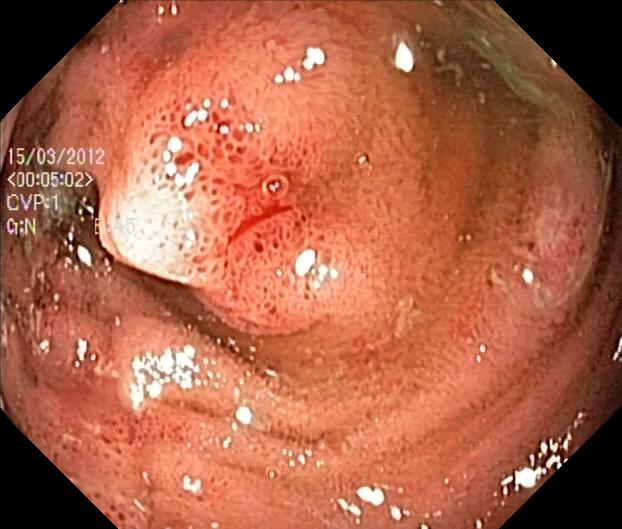

In [4]:
img = Image.open('./train/images/train/cju0qkwl35piu0993l0dewei2.jpg')
img.show()

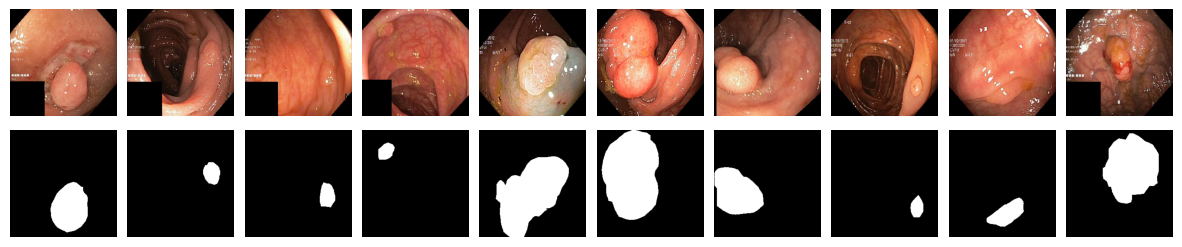

In [5]:
plot_images(valid_images_generator, valid_masks_generator, batch_size=16)

# Smaller U-Net Training

In [6]:
# Data configurations
batch_size = 8
epochs = 100


# Get data
train_images_generator, train_masks_generator, valid_images_generator, valid_masks_generator = data_generator_creator(seed=123,
                                                                                                                      target_size=(256, 256),
                                                                                                                      batch_size=batch_size,
                                                                                                                      train_dir='./train/',
                                                                                                                      valid_dir='./valid/')

train_generator = zip(train_images_generator, train_masks_generator)
valid_generator = zip(valid_images_generator, valid_masks_generator)


# Image attributes
_, height, width, channels= train_images_generator.next().shape
input_shape = (height, width, channels)


# Create model
model = smaller_u_net(input_shape=input_shape)

total_params = model.count_params()
print(f"\nTotal number of parameters: {total_params:,}")


# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,
                                     beta_1=0.9)

# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient, iou_coefficient])


# Check if previous model is present.
checkpoint_dir = './model_checkpoints/smaller_u_net_checkpoints/'

try:
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    print('Model loaded successfully from checkpoint.')
except:
    print(f'No model was found in the directory {checkpoint_dir}')


# Model training configurations
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              min_lr=1e-6)

cp_callback = ModelCheckpoint(
    filepath=checkpoint_dir,
    verbose=1, 
    save_weights_only=True
)

steps_per_epoch = train_images_generator.samples // batch_size
valid_steps = valid_images_generator.samples // batch_size

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


2024-08-18 20:44:31.087398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-18 20:44:31.153252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-18 20:44:31.153300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-18 20:44:31.156103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-18 20:44:31.156156: I tensorflow/compile


Total number of parameters: 16,495,553
No model was found in the directory ./model_checkpoints/smaller_u_net_checkpoints/


2024-08-18 20:44:31.948493: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ./model_checkpoints/smaller_u_net_checkpoints/.: FAILED_PRECONDITION: model_checkpoints/smaller_u_net_checkpoints; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[early_stopping, reduce_lr, cp_callback]
)

Epoch 1/100


2024-08-16 16:49:25.528642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-08-16 16:49:25.989396: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-16 16:49:26.389425: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-16 16:49:27.108327: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-16 16:49:27.538230: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were avail

100/100 [==============================] - ETA: 0s - loss: 6.4926 - accuracy: 0.7857 - dice_coefficient: 0.1924 - iou_coefficient: 0.1073
Epoch 1: saving model to ./model_checkpoints/smaller_u_net_checkpoints/
100/100 [==============================] - 70s 496ms/step - loss: 6.4926 - accuracy: 0.7857 - dice_coefficient: 0.1924 - iou_coefficient: 0.1073 - val_loss: 5.0376 - val_accuracy: 0.8447 - val_dice_coefficient: 0.2068 - val_iou_coefficient: 0.1160 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.0358 - accuracy: 0.8298 - dice_coefficient: 0.1618 - iou_coefficient: 0.0883
Epoch 2: saving model to ./model_checkpoints/smaller_u_net_checkpoints/
100/100 [==============================] - 50s 496ms/step - loss: 4.0358 - accuracy: 0.8298 - dice_coefficient: 0.1618 - iou_coefficient: 0.0883 - val_loss: 3.2590 - val_accuracy: 0.8449 - val_dice_coefficient: 0.2091 - val_iou_coefficient: 0.1171 - lr: 1.0000e-04
Epoch 3/100
100/100 [=================

KeyboardInterrupt: 

# DuckNet Training

In [11]:
# Data configurations
batch_size = 4
epochs = 100


# Get data
train_images_generator, train_masks_generator, valid_images_generator, valid_masks_generator = data_generator_creator(seed=123,
                                                                                                                      target_size=(256, 256),
                                                                                                                      batch_size=batch_size,
                                                                                                                      train_dir='./train/',
                                                                                                                      valid_dir='./valid/')

train_generator = zip(train_images_generator, train_masks_generator)
valid_generator = zip(valid_images_generator, valid_masks_generator)


# Image attributes
_, height, width, channels= train_images_generator.next().shape
input_shape = (height, width, channels)


# Create model
model = ducknet(input_shape=input_shape, start_filters=17)

total_params = model.count_params()
print(f"\nTotal number of parameters: {total_params:,}")


# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient, iou_coefficient])


# Check if previous model is present.
checkpoint_path = "model_checkpoints/ducknet_checkpoints/cp_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

try:
    checkpoint_files = os.listdir(checkpoint_dir)
    checkpoint_prefixes = sorted([f.split('.')[0] for f in checkpoint_files if f.endswith('.index')])
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_prefixes[-1]+'.ckpt')
    model.load_weights(latest_checkpoint)
    print(f'Model loaded successfully from checkpoint: {latest_checkpoint}')
except:
    print(f'No model was found in the directory {checkpoint_dir}')


# Model training configurations
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              min_lr=1e-7)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              verbose=1, 
                              save_weights_only=True
)

initial_epoch = int(checkpoint_prefixes[-1].lstrip('cp_'))

model.save_weights(checkpoint_path.format(epoch=initial_epoch))

steps_per_epoch = train_images_generator.samples // batch_size
valid_steps = valid_images_generator.samples // batch_size

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.

Total number of parameters: 33,017,401
No model was found in the directory model_checkpoints/ducknet_checkpoints


TypeError: save_weights() got an unexpected keyword argument 'include_optimizer'

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[early_stopping, reduce_lr, cp_callback]
)

Epoch 36/100
200/200 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8312 - dice_coefficient: 0.1854 - iou_coefficient: 0.1027
Epoch 36: saving model to model_checkpoints/ducknet_checkpoints/cp_0036.ckpt
200/200 [==============================] - 258s 749ms/step - loss: 0.4044 - accuracy: 0.8312 - dice_coefficient: 0.1854 - iou_coefficient: 0.1027 - val_loss: 0.3696 - val_accuracy: 0.8449 - val_dice_coefficient: 0.2158 - val_iou_coefficient: 0.1217 - lr: 1.0000e-04
Epoch 37/100
200/200 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8341 - dice_coefficient: 0.1780 - iou_coefficient: 0.0982
Epoch 37: saving model to model_checkpoints/ducknet_checkpoints/cp_0037.ckpt
200/200 [==============================] - 106s 529ms/step - loss: 0.3992 - accuracy: 0.8341 - dice_coefficient: 0.1780 - iou_coefficient: 0.0982 - val_loss: 0.3780 - val_accuracy: 0.8449 - val_dice_coefficient: 0.1964 - val_iou_coefficient: 0.1095 - lr: 1.0000e-04
Epoch 38/100

In [10]:
help(model.save)

Help on method save in module keras.src.engine.training:

save(filepath, overwrite=True, save_format=None, **kwargs) method of keras.src.engine.functional.Functional instance
    Saves a model as a TensorFlow SavedModel or HDF5 file.
    
    See the [Serialization and Saving guide](
        https://keras.io/guides/serialization_and_saving/) for details.
    
    Args:
        model: Keras model instance to be saved.
        filepath: `str` or `pathlib.Path` object. Path where to save the
            model.
        overwrite: Whether we should overwrite any existing model at the
            target location, or instead ask the user via an interactive
            prompt.
        save_format: Either `"keras"`, `"tf"`, `"h5"`,
            indicating whether to save the model
            in the native Keras format (`.keras`),
            in the TensorFlow SavedModel format
            (referred to as "SavedModel" below),
            or in the legacy HDF5 format (`.h5`).
            Defaults

# DuckNet with fewer filters

In [18]:
# Data configurations
batch_size = 8
epochs = 100


# Get data
train_images_generator, train_masks_generator, valid_images_generator, valid_masks_generator = data_generator_creator(seed=123,
                                                                                                                      target_size=(256, 256),
                                                                                                                      batch_size=batch_size,
                                                                                                                      train_dir='./train/',
                                                                                                                      valid_dir='./valid/')

train_generator = zip(train_images_generator, train_masks_generator)
valid_generator = zip(valid_images_generator, valid_masks_generator)


# Image attributes
_, height, width, channels= train_images_generator.next().shape
input_shape = (height, width, channels)


# Create model
model = ducknet(input_shape=input_shape, start_filters=10)

total_params = model.count_params()
print(f"\nTotal number of parameters: {total_params:,}")


# Check if previous model is present.
checkpoint_path = "model_checkpoints/smaller_ducknet_checkpoints/cp_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

try:
    checkpoint_files = os.listdir(checkpoint_dir)
    checkpoint_prefixes = sorted([f.split('.')[0] for f in checkpoint_files if f.endswith('.index')])
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_prefixes[-1]+'.ckpt')
    model.load_weights(latest_checkpoint)
    print(f'Model loaded successfully from checkpoint: {latest_checkpoint}')
except:
    print(f'No model was found in the directory {checkpoint_dir}')


# Model training configurations
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              min_lr=1e-7)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              verbose=1, 
                              save_weights_only=True
)

try:
    initial_epoch = int(checkpoint_prefixes[-1].lstrip('cp_'))
except:
    initial_epoch = 0

steps_per_epoch = train_images_generator.samples // batch_size
valid_steps = valid_images_generator.samples // batch_size

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile model
model.compile(optimizer=optimizer,
              loss=dice_loss,
              metrics=['accuracy', dice_coefficient, iou_coefficient])

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.

Total number of parameters: 11,450,611
Model loaded successfully from checkpoint: model_checkpoints/smaller_ducknet_checkpoints/cp_0045.ckpt


In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[early_stopping, reduce_lr, cp_callback]
)

Epoch 46/100


2024-08-21 20:23:47.814066: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-21 20:23:49.492697: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-21 20:23:49.600526: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-21 20:23:49.945596: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

# Rough Workings for Gradient Checkpointing

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
tf.keras.backend.clear_session()

#tf.keras.backend.set_floatx('float16')

#mixed_precision.set_global_policy('mixed_float16')

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [ ]:
# Load Model
model = u_net(input_shape=input_shape)
recompute_grad_model = tf.recompute_grad(model)

# Define loss function and optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-5)

# Training step function
@tf.function
def train_step(images, masks):
    with tf.GradientTape() as tape:
        predictions = recompute_grad_model(images, training=True)
        loss = loss_fn(masks, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# Training loop
def train(epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for step in range(steps_per_epoch):
            images, masks = next(train_generator)
            loss = train_step(images, masks)
            if (step+1) % 20 == 0:
                print(f"Step {step+1}, Loss: {loss.numpy():.4f}")
                

In [ ]:
train(epochs=5)